# Image tearing

Aussi appelé shearing, ou plus communément skewing

**Pour reproduire l'effet de tearing VHS, nous allons effectuer:**

- selection d'une bande sur l'image de base
- skewing de la bande
- remise de la bande à taille de l'image
- fusion de la bande à l'image

**Pour lancer directement le pipeline :** [ancre](#Pipeline-final)

In [ ]:
import os
import sys
import random
from PIL import Image, ImageFilter, ImageTransform

In [ ]:
DATASET_PATH = os.path.join(os.getcwd(), "input")
IMG_PATH  = os.path.join(os.getcwd(), "input", "1.jpg")
random.seed(42)

*Fonction de skewing*

In [ ]:
def _skewX(img):
    width, height = img.size
    m = random.randint(2, 8)/10 
    xshift = abs(m) * width
    new_width = width + int(round(xshift))
    x1 = img.size[0]
    img = img.transform((new_width, height), Image.AFFINE, (1, m, -xshift if m > 0 else 0, 0, 1, 0), Image.BICUBIC)
    x2 = img.size[0]
    xDifference = x2 - x1
    return img, xDifference

*Fonction de crop de la box skewed trop grande pour être fusionnée avec l'image de base*

Il faut enlever la différence entre image de base et la skewed pour retrouver la taille normale.
On enlève la majeur partie à gauche de l'image (car le skew se fait vers la droite) et le reste à droite.

In [ ]:
def _cropSkewed(img, xDifference):
    x1 = (95*xDifference)/100
    y1 = 0
    x2 = img.width - (5*xDifference)/100
    y2 = img.height
    box = (x1, y1, x2, y2)
    cropped = img.crop(box)
    display(img)
    display(cropped)
    return cropped

*Fonction de création d'une box*

In [ ]:
def _createBoxRandom(img):
    width, height = img.size
    x1 = 0
    y1 = random.randint(0, height)  
    x2 = width
    y2 = y1 + random.randint(2, 6) 
    box = (x1, y1, x2, y2)
    return (box)

# Exemples

**Image de base**

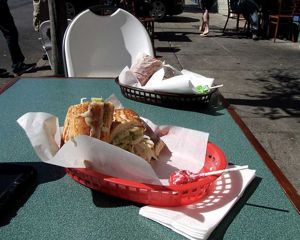

In [23]:
img = Image.open(IMG_PATH)

# Display une petite version de la photo, juste pour optimiser l'espace
thumbnailImg = Image.open(IMG_PATH)
thumbnailImg.thumbnail((300, 300))
display(thumbnailImg)

**Skew test**

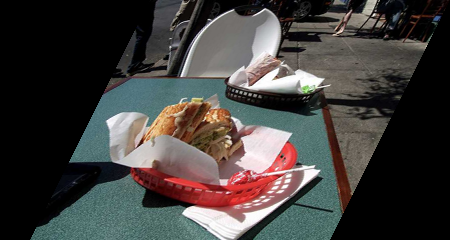

In [24]:
img, xDifference  = _skewX(thumbnailImg)
display(img)

## Condition réelle

**Crop un morceau de l'image**

In [25]:
img = Image.open(IMG_PATH)
boxOnImage = _createBoxRandom(img)
crop = img.crop(boxOnImage)

print(boxOnImage)
display(crop)

(0, 104, 720, 114)


**Skewing**

In [26]:
skewed, xDifference = _skewX(crop)

**Crop du skew**

In [27]:
croppedSkewed = _cropSkewed(skewed, xDifference)

**Paste le crop avec l'image de base**

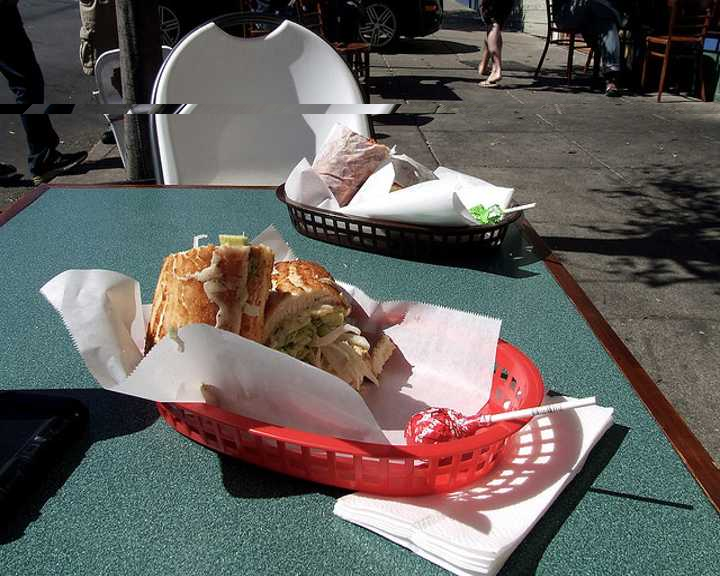

In [28]:
x1, y1, x2, y2 = boxOnImage
img.paste(croppedSkewed, (x1, y1))

display(img)
img.save('data/test.png')

# Pipeline final

**Setup**

In [42]:
import os
import sys
import random
from PIL import Image, ImageFilter, ImageTransform

### DATASET_PATH définit le dossier où chercher les images d'input
DATASET_PATH = os.path.join(os.getcwd(), "input")
random.seed(42)

def _skewX(img):
    width, height = img.size
    m = random.randint(4, 10)/10 
    xshift = abs(m) * width
    new_width = width + int(round(xshift))
    x1 = img.size[0]
    img = img.transform((new_width, height), Image.AFFINE, (1, m, -xshift if m > 0 else 0, 0, 1, 0), Image.BICUBIC)
    x2 = img.size[0]
    xDifference = x2 - x1
    return img, xDifference

def _cropSkewed(img, xDifference):
    x1 = (95*xDifference)/100
    y1 = 0
    x2 = img.width - (5*xDifference)/100
    y2 = img.height
    box = (x1, y1, x2, y2)
    cropped = img.crop(box)
    return cropped

def _createBoxRandom(img):
    width, height = img.size
    x1 = 0
    y1 = random.randint(0, height)  
    x2 = width
    y2 = y1 + random.randint(5, 10) 
    box = (x1, y1, x2, y2)
    return (box)

def _rotate(img, name):
    # Rotate et remet au format VHS
    img = img.transpose(method=Image.TRANSPOSE)
    img = img.resize((720, 576), Image.LANCZOS)
    img = _process(img)
    img.save('output/' + name + '_tearing_rotate.jpg')
#     display(img)
    
def _mirror(img, name):
    # Mirror l'image 
    img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
    img = _process(img)
    img.save('output/' + name + '_tearing_mirror.jpg')
#     display(img)
    
def _normal(img, name):
    # Skew sans changer l'image de base
    img = _process(img)
    img.save('output/' + name + '_tearing.jpg')
#     display(img)
    
def _process(img):
    """
     - selection d'une bande sur l'image de base
     - skewing de la bande
     - remise de la bande à taille de l'image
     - fusion de la bande à l'image
    """
    boxOnImage = _createBoxRandom(img)
    crop = img.crop(boxOnImage)
    skewed, xDifference = _skewX(crop)
    croppedSkewed = _cropSkewed(skewed, xDifference)
    x1, y1, x2, y2 = boxOnImage
    img.paste(croppedSkewed, (x1, y1))
    return img

def skewPipeline(img_path, name):
    baseImg = Image.open(img_path)
    # Il faut laisser _normal en dernier, parce qu'elle écrase l'image de base, pour une raison inconnue
    _mirror(baseImg, name)
    _rotate(baseImg, name)
    _normal(baseImg, name)

**Pipeline**

In [44]:
for file in os.listdir(DATASET_PATH):    
    if(file.__contains__('.jpg')):
        name = file.split('.')[0]
        IMG_PATH = os.path.join(DATASET_PATH, file)
        skewPipeline(IMG_PATH, name)